# Purpose
This example demonstrates how to access method results in Dakota's HDF5 output. Specifically, statistics computed by an incremental sampling study are plotted. In addition to numerical results, metadata (the number of samples, a probability level ) are extracted from a group attirbute and a dataset dimension scale. Complete details about the organization of results and evaluation data in Dakota's HDF5 output are available in the [Reference Manual](https://dakota.sandia.gov/content/latest-reference-manual). The [h5py](https://www.h5py.org/) documentation is also a valuable resource.

## Study Details

The simulation that Dakota runs is the `text_book` function, which is documented in both the User's and Reference Manuals. There are four normally distributed variables, **x1**-**x4**, and one response, **f**. The method was assigned the ID "my_sampling".

To (re)generate the results output, run `dakota -i dakota_refine.in`.

---
Begin by importing`h5py` and other required modules.

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt

In this example, we will examine how a few statistics converge as the number of samples is increased from 5 to 160. When the `refinement_samples` keyword is present, results from a sampling study are nested in groups named `increment:<N>`, where `<N>` is an integer index (beginning with 1) for the refinement.

## Moments

Let's first examine the mean and standard deviation of **f** and their 95% confidence bounds. These are stored in the datasets
* `increment<N>/moments/f`: 1D dataset contaiing the four moments: mean, standard deviation, skewness, and kurtosis
* `increment<N>/moment_confidence_intervals/f`: 2D dataset containing the lower and upper confidence bounds on the mean and standard deviation

Our approach will be to iterate the increment groups to collect the moment, standard deviation, and bounds into numpy arrays. Then we'll make the plots.



In [2]:
# Use a context manager (i.e. "with") to ensure the file is closed properly
with h5py.File("dakota_results.h5","r") as h:
    # Create the results group object for convenience. Note that we specified 'my_sampling'
    # as the id_method of our method in our Dakota input file.
    results = h["/methods/my_sampling/results/execution:1"]
    # Get the number of increments
    num_increments = len(results.keys())
    num_samples = np.empty((num_increments,),int) # storage for the number of samples in
                                                  # each increment
    means = np.empty((num_increments,3))          # storage for the lower bound, mean, and 
                                                  # upper bound
    std_deviations = np.empty((num_increments,3)) # storage for the lower bound, standard 
                                                  # deviation, and upper bound
    # We must construct the names of the increment groups to make sure we get them in the right
    # order:
    for i in range(num_increments):
        inc_group = results["increment:%d" % (i+1,)]
        # The number of samples in the increment is stored in the samples attribute of the group.
        # (Also, the TOTAL number of samples is stored in the samples attribute of the execution
        # group)
        num_samples[i] = inc_group.attrs["samples"]
        # Means
        means[i,0] = inc_group["moment_confidence_intervals/f"][0,0]  # lower bound on the mean
        means[i,1] = inc_group["moments/f"][0] # mean
        means[i,2] = inc_group["moment_confidence_intervals/f"][1,0]  # upper bound on the mean
        # Standard deviations
        std_deviations[i,0] = inc_group["moment_confidence_intervals/f"][0,1]  # lower boound on
                                                                               # the std deviation
        std_deviations[i,1] = inc_group["moments/f"][1] # standard deviation
        std_deviations[i,2] = inc_group["moment_confidence_intervals/f"][1,1]  # upper bound on
                                                                               # the std devaiation


### Plot Mean

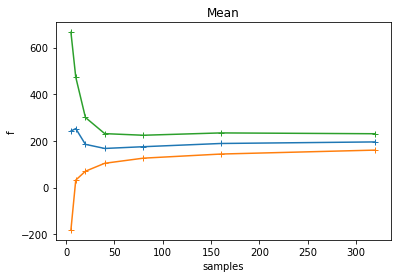

In [3]:
plt.title("Mean")
plt.xlabel("samples")
plt.ylabel("f")
plt.plot(num_samples,means[:,1],"+-", label="mean")
plt.plot(num_samples,means[:,0],"+-", label="lower")
plt.plot(num_samples,means[:,2],"+-", label="upper")


### Plot Standard Deviation

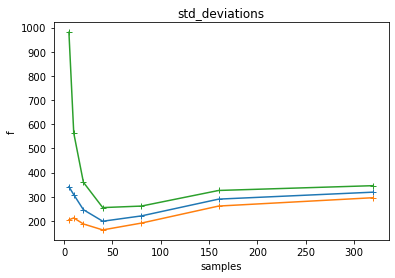

In [4]:
plt.title("std_deviations")
plt.xlabel("samples")
plt.ylabel("f")
plt.plot(num_samples,std_deviations[:,1],"+-", label="Standard Devaiation")
plt.plot(num_samples,std_deviations[:,0],"+-", label="lower")
plt.plot(num_samples,std_deviations[:,2],"+-", label="upper")


## Probability Levels

The study also computed the 90th percentile on **f**.

In [5]:
# Use a context manager (i.e. "with") to ensure the file is closed properly
with h5py.File("dakota_results.h5","r") as h:
    # Create the results group object for convenience. Note that we specified 'my_sampling'
    # as the id_method of our method in our Dakota input file.
    results = h["/methods/my_sampling/results/execution:1"]
    # Get the number of increments
    num_increments = len(results.keys())
    num_samples = np.empty((num_increments,),int)  # storage for the number of samples in each
                                                   # increment
    plevels = np.empty((num_increments,)) # store the percentile for each increment
    # We must construct the names of the increment groups to make sure we get them in the right
    # order:
    for i in range(num_increments):
        inc_group = results["increment:%d" % (i+1,)]
        # The number of samples in the increment is stored in the samples attribute of the group.
        # (Also, the TOTAL number of samples is stored in the samples attribute of the execution
        # group)
        num_samples[i] = inc_group.attrs["samples"]
        # percentile
        plevels[i] = inc_group["probability_levels/f"][0] # standard deviation
    # To make this code snippet more generic, get the actual requested probability_level from the
    # first increment. This information is stored in a dimension scale on the dataset. It's the
    # scale for the 0th dimension, the 0th scale on that dimension, and the 0th item in that
    # scale: dims[0][0][0]
    req_level = results["increment:1/probability_levels/f"].dims[0][0][0]
        

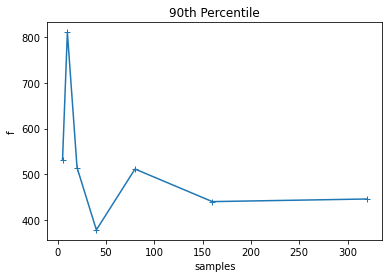

In [6]:
plt.title("%gth Percentile" % (100.0*req_level,))
plt.xlabel("samples")
plt.ylabel("f")
plt.plot(num_samples,plevels,"+-", label="lower")